# Importing outputs after running matlab

# Environment

In [1]:
# conda activate mri
import numpy as np
import pandas as pd
import scipy as sp
from glob import glob
import scipy.io as sio
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
import mat73

# plotting
from nilearn.plotting import plot_connectome, view_connectome #, plot_connectome_strength
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText

# custom functions
import myfx_cpm_visual as cpm_visual

### Helper functions

In [3]:
def mysavefig(figure,out_dir,outname):
    g.savefig(f'{out_dir}/{outname}.png', format='png', transparent = True, dpi=300)

In [4]:
mycolors = [
    '#aa1016',
    '#FC9272',
    '#0b559f',
    '#539ecd'
]
mypalette = sns.color_palette(mycolors)
mypalette

[(0.6666666666666666, 0.06274509803921569, 0.08627450980392157),
 (0.9882352941176471, 0.5725490196078431, 0.4470588235294118),
 (0.043137254901960784, 0.3333333333333333, 0.6235294117647059),
 (0.3254901960784314, 0.6196078431372549, 0.803921568627451)]

# INPUTS

In [12]:
main_proj = '/projects/swglab/data/BANDA_U01/analysis/proj_franci_anxiety'
out_dir='/projects/swglab/data/BANDA_U01/scripts/proj_franci_anxiety/jccp/outputs/cpm'
all_behave_f= f'{main_proj}/behave_inputs/abcd_dcan/abcd_dcan_allsubjs_10min.csv'

# info atlas 
coords_f = f'{main_proj}/conn_projects/in_rois/gordon352/gordon352_yeo7_coords.csv'
atlas_dir = f'{main_proj}/cpm/abcd_dcan/10min/connectomes'
final_model='cbcl_scr_syn_anxdep_t_y1_gordon352_2fold_spearman_partialcovar_cbcl_scr_syn_anxdep_t_blmeanFDjsex_xinterview_age_bl_p0.001_FD0.25_allsubjs'

results_dir = f'{main_proj}/cpm/abcd_dcan/10min/outputs/{final_model}'
extval_f = glob(f'{main_proj}/cpm/cross_datasets_external_validation/*10min*{final_model}*rcads_tot_t__T3.csv')[0]

behave_f = f'{results_dir}/data_used.csv'
results_f = f'{results_dir}/results.mat'

pred_obs_f = glob(f'{main_proj}/cpm/cross_datasets_external_validation/*10min*{final_model}*rcads_tot_t__T3*DATA*.csv')[0]

p_mat_orig_f = f'{results_dir}/linear_reg_model/p_mat.mat'
r_mat_orig_f = f'{results_dir}/linear_reg_model/r_mat.mat'

pos_f = f'{results_dir}/linear_reg_model/pos_mask.txt'
neg_f = f'{results_dir}/linear_reg_model/neg_mask.txt'

net_cols = {"positive":'#7570b3',
            "negative":'#1b9377',
            "combined":'#ff0000'}

# Load data ABCD

In [13]:
# behave used in the analysis
behave = pd.read_csv(behave_f).set_index('participant_id')
behave = behave[behave['excluded'] == 0] # retaining only subjs used in the model

# predicted vs observed behavioral values in-sample
pred_obs = pd.read_csv(pred_obs_f)

# extval = pd.read_csv(extval_f)

# atlas info 
atlas_coords = pd.read_csv(coords_f, index_col="nodeNo")
my_coords = atlas_coords[['x','y','z']]

# results
r_mat_orig = sio.loadmat(r_mat_orig_f)
p_mat_orig = sio.loadmat(p_mat_orig_f)
results = sio.loadmat(results_f)
true_results = sio.loadmat(f'{results_dir}/true_data/R_iterations.mat')

r = pd.DataFrame(data ={'R':results['R'][0],'pval':results['p_all'][0]}, index = ['positive','negative','combined'])#.round(3)
conditions = [
    (r['pval'] > 0.1),
    ((r['pval'] <= 0.1) & (r['pval'] > 0.05)),
    ((r['pval'] <= 0.05) & (r['pval'] > 0.01)),
    ((r['pval'] <= 0.01) & (r['pval'] > 0.001)),
    (r['pval'] <= 0.001),
]
values = ['n.s.','trending','*', '**', '***']
r['sig'] = np.select(conditions, values)

In [14]:
# results masks
grab_col='best_match' #'gordon_network'#'gordon_original_label'#'best_match' #from atlas
# origpos = pd.read_csv(pos_f, header=None)
origpos = pd.read_csv(pos_f, sep = "   ",header=None, engine='python')
origpos = pd.DataFrame(origpos.values,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()
# origpos = pd.DataFrame(origpos,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()

# origneg = pd.read_csv(neg_f,header=None)
origneg = pd.read_csv(neg_f, sep = "   ",header=None, engine='python')
origneg = pd.DataFrame(origneg.values,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()

assert np.diag(origneg).sum() ==0, 'Something is wrong with the origneg mask,diagnoal is not 0'
assert np.diag(origpos).sum() ==0, 'Something is wrong with the origpos mask,diagnoal is not 0'

# n=origneg
# origneg = sp.spatial.distance.squareform(origneg) #vector form
# origneg= np.tril(origneg,0)
# origneg = pd.DataFrame(origneg,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()

pos100=origpos
neg100=origneg
origcomb=pos100+neg100
comb100=origcomb

assert np.diag(pos100).sum() ==0, 'Something is wrong with the pos mask,diagnoal is not 0'
assert np.diag(neg100).sum() ==0, 'Something is wrong with the neg mask,diagnoal is not 0'
assert comb100.max().max() <=1, 'Something is wrong with the combined mask, max value is >1'

# all behave
all_behave = pd.read_csv(all_behave_f)
all_behave.set_index('participant_id', inplace=True)
all_behave = all_behave[all_behave.index.notnull()] #drop rows that dont refer to any sub-BANDAxxx

# Load Connectomes ABCD

In [8]:
# # old dont use 
# # connectomes = cpm.read_in_matrices_new(behave.index, f'{atlas_dir}/', 'brainnetome246', file_sutffix='') # subj x connectomes (1 vector per subjs)

# print('loading mats')
# all_mats = mat73.loadmat(f'{atlas_dir}/gordon352_allsubjs_all_mats.mat')
# # all_mats = sio.loadmat(f'{atlas_dir}/gordon352_allsubjs_all_mats.mat')
# tmp = {}
# print('storing into dataframe')
# for i,sub in enumerate(behave.index):
#     tmp[sub] =all_mats['atlas_all_mats'][:,:,i][np.triu_indices_from(all_mats['atlas_all_mats'][:,:,i], k=1)]
# connectomes = pd.DataFrame.from_dict(tmp, orient='index')
# connectomes = connectomes.loc[behave.index]
# print('mats loaded')

In [9]:
# connectomes.shape

In [10]:
# mean_connectomes = pd.DataFrame(connectomes.mean(axis=0), columns=['mean_allsubjs']).T.copy()

# Load Connectomes BANDA

In [7]:
# all behave
all_beh_banda = pd.read_csv('/projects/swglab/data/BANDA_U01/analysis/proj_franci_anxiety/behave_inputs/banda/banda_allsubjs_washu.csv')
all_beh_banda['participant_id'] = all_beh_banda['src_subject_id']
all_beh_banda.set_index('participant_id', inplace=True)

final_banda = pd.read_csv('/projects/swglab/data/BANDA_U01/analysis/proj_franci_anxiety/behave_inputs/consort_final_sample_banda_n150.csv', sep = ',') #this is what was used
final_banda = final_banda.set_index('participant_id')

#create only two groups
final_banda['group'] = final_banda['ksads_diagnoses01_ksads_group_T1']
final_banda.loc[final_banda["group"] == "depressed", "group"] = "Depressed-Anxious"
final_banda.loc[final_banda["group"] == "anxious", "group"] = "Depressed-Anxious"
final_banda.loc[final_banda["group"] == "comorbid", "group"] = "Depressed-Anxious"
final_banda.loc[final_banda["group"] == "hc", "group"] = "Controls"

In [8]:
print('loading mats')
# all_mats_banda = mat73.loadmat('/projects/swglab/data/BANDA_U01/analysis/proj_franci_anxiety/cpm/banda/washu/connectomes/gordon352_allsubjs_all_mats.mat')
all_mats_banda = sio.loadmat('/projects/swglab/data/BANDA_U01/analysis/proj_franci_anxiety/cpm/banda/washu/connectomes/gordon352_allsubjs_all_mats.mat')
# all_mats = sio.loadmat(f'{atlas_dir}/gordon352_allsubjs_all_mats.mat')
tmp = {}
print('storing into dataframe')
for i,sub in enumerate(all_beh_banda.index):
    tmp[sub] = all_mats_banda['atlas_all_mats'][:,:,i][np.triu_indices_from(all_mats_banda['atlas_all_mats'][:,:,i], k=1)]
connectomes_banda = pd.DataFrame.from_dict(tmp, orient='index')
connectomes_banda = connectomes_banda.loc[all_beh_banda.index]
print('mats loaded')

loading mats
storing into dataframe
mats loaded


In [9]:
connectomes_banda.shape

(202, 61776)

In [10]:
mean_connectomes_banda = pd.DataFrame(connectomes_banda.mean(axis=0), columns=['mean_allsubjs']).T.copy()

# Customize Networks

In [11]:
# # remove parcels that did not have any matching
drop_col1='none'
pos100_cleaned=origpos.drop(drop_col1, axis=1).drop(drop_col1, axis=0).copy()
neg100_cleaned=origneg.drop(drop_col1, axis=1).drop(drop_col1, axis=0).copy()
comb100_cleaned=origcomb.drop(drop_col1, axis=1).drop(drop_col1, axis=0).copy()
atlas_coords_cleaned = atlas_coords[atlas_coords[grab_col] != drop_col1]

drop_col2='cerebellum'
pos100_cleaned=pos100_cleaned.drop(drop_col2, axis=1).drop(drop_col2, axis=0).copy()
neg100_cleaned=neg100_cleaned.drop(drop_col2, axis=1).drop(drop_col2, axis=0).copy()
comb100_cleaned=comb100_cleaned.drop(drop_col2, axis=1).drop(drop_col2, axis=0).copy()
atlas_coords_cleaned = atlas_coords_cleaned[atlas_coords_cleaned[grab_col] != drop_col2]

# order in which networks will be listed in triangular matrices
yeo_net_order=['dan','dmn','fpn','limbic','smn','van','visual','subcx']

# Permutation Testing Distributions

In [12]:
r

,R,pval,sig
positive,0.045684,0.032,*
negative,0.063925,0.055,trending
combined,0.057789,0.040,*


In [13]:
len(results['R_permute_all'])

999

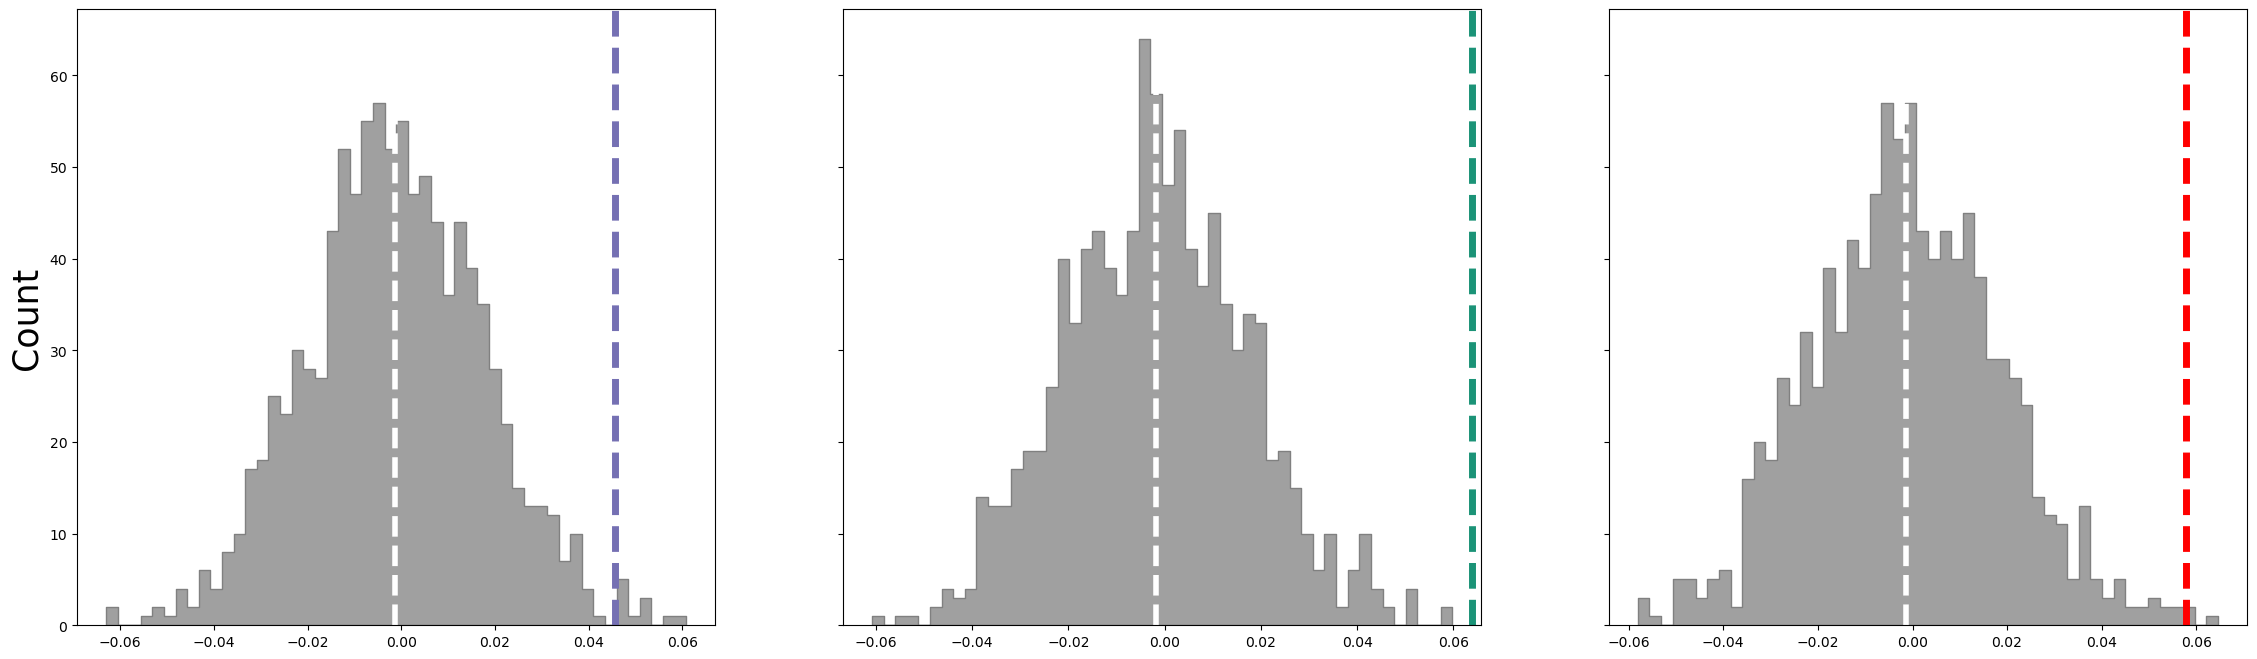

In [14]:
fig, ax = plt.subplots(1,3, figsize=(28,8), sharey=True)
for tail in range(3):
    if tail==0:
        grab='positive'
    elif tail==1:
        grab='negative'
    elif tail==2:
        grab='combined'

    tmp = results['R_permute_all'][:,tail]
    g = sns.histplot(tmp, bins = 50, color = 'grey', ax = ax[tail], element = 'step');#x="flipper_length_mm", hue="species", element="step")

    g.axvline(tmp.mean(), color = 'white', ls = '--', linewidth=4)
    g.axvline(r.iloc[tail]['R'], color = net_cols[grab], ls = '--', linewidth=5)
    g.set_ylabel('Count', fontsize=25)

#save to file
g = fig.get_figure()
mysavefig(g,out_dir,'abcd_permutation_distributions') 

real data

## Predicted vs Observed

In [18]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

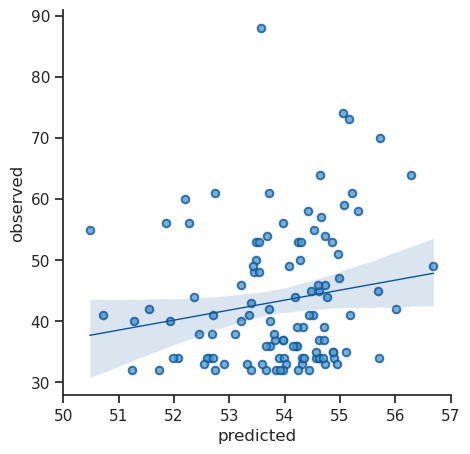

In [19]:
tmp = pd.concat([pred_obs,final_banda.reset_index()], axis =1)
tmp = tmp[tmp['include'] == 1]
myx='predicted'
myy='observed'

####################################
fig, ax =  plt.subplots(1,1, figsize = (5,5), sharex = False, sharey= False)

g = sns.regplot(data=tmp, y=myy, x=myx, ci = 95,# ax = ax[0],
                    scatter_kws={'s':30, "alpha":0.8,'linewidths':1.4, 'edgecolor' : mypalette[2],},
                    line_kws={"lw":1, 'color' : mypalette[2]},# hue='ksads_diagnoses01_ksads_group_T1',
                    color = mypalette[3], 
                   ).set( xlabel=myx, ylabel=myy);
plt.xlim(50, 57)

fig.show()
#save to file
g = fig.get_figure()
mysavefig(g,out_dir,'banda_predicted_observed') 

# Define Positive and Negative edges 
(this is based on BANDA FC-to-symptom severity correlation)

<Axes: xlabel='best_match', ylabel='best_match'>

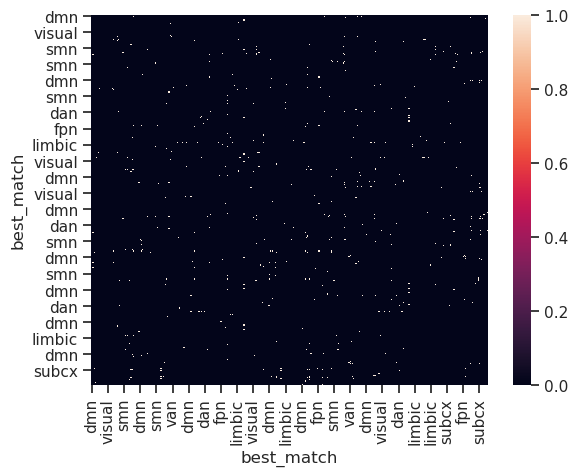

In [29]:
sns.heatmap(comb100_cleaned)

In [32]:
# Define the dependent variable (x) and the independent variables (covariates)
y = final_banda['rcads01_rcads_tot_t_T3']
X = final_banda[['rcads01_rcads_tot_t_T1','interview_age_T1','sex01_T1','Movement_RelativeRMS_mean_T1']]

# Add a constant term to the independent variables for the intercept
X = sm.add_constant(X)

# Fit the ordinary least squares (OLS) regression model
model = sm.OLS(y, X).fit()

# Calculate residuals
final_banda['res'] = model.resid

this takes a while

In [33]:
from scipy.stats import spearmanr

tmp_conn = connectomes_banda.loc[final_banda.index]

# Initialize a dictionary to store results
results = {}

# Compute Spearman correlation for each column in dataframe2
for col in connectomes_banda.columns:
    correlation, _ = spearmanr(final_banda['rcads01_rcads_tot_t_T3'], tmp_conn[col])
    results[col] = "Positive" if correlation > 0 else "Negative"

# Convert results to a DataFrame
results_df = pd.DataFrame(list(results.items()), columns=['Column', 'Correlation Sign'])
results_df['pos'] = results_df['Correlation Sign'].apply(lambda x: 1 if x == 'Positive' else 0)
results_df['neg'] = results_df['Correlation Sign'].apply(lambda x: 1 if x == 'Negative' else 0)
results_df = results_df.drop('Column', axis=1)
results_df = results_df.T.copy()
results_df

,0,1,2,3,4,5,6,7,8,9,...,61766,61767,61768,61769,61770,61771,61772,61773,61774,61775
Correlation Sign,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Positive,Positive,...,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
pos,0,1,1,1,1,1,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
neg,1,0,0,0,0,0,0,1,0,0,...,1,0,1,1,1,1,1,1,1,1


In [34]:
pos_banda = results_df.loc[['pos']]
neg_banda = results_df.loc[['neg']]
pos_banda

,0,1,2,3,4,5,6,7,8,9,...,61766,61767,61768,61769,61770,61771,61772,61773,61774,61775
pos,0,1,1,1,1,1,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0


In [35]:
n = 352

# Initialize an empty matrix
original_matrix_pos = np.zeros((n, n))
original_matrix_neg = np.zeros((n, n))

# Fill the upper triangle (excluding the diagonal) with the flattened data
upper_indices = np.triu_indices(n, k=1)  # Indices for upper triangle excluding diagonal
original_matrix_pos[upper_indices] = pos_banda
original_matrix_neg[upper_indices] = neg_banda

# Mirror the upper triangle to the lower triangle to make it symmetrical
original_matrix_pos = original_matrix_pos + original_matrix_pos.T
original_matrix_neg = original_matrix_neg + original_matrix_neg.T

## Convert to a DataFrame for further use
# origpos_banda = pd.DataFrame(original_matrix_pos) #these are based on banda. now i need to mask out the nodes that were not sig in ABCD
# origneg_banda = pd.DataFrame(original_matrix_neg) #these are based on banda. now i need to mask out the nodes that were not sig in ABCD



# Convert to a DataFrame for further use
origpos_banda = pd.DataFrame(original_matrix_pos) #these are based on banda. now i need to mask out the nodes that were not sig in ABCD
origneg_banda = pd.DataFrame(original_matrix_neg) #these are based on banda. now i need to mask out the nodes that were not sig in ABCD
origpos_banda = pd.DataFrame(origpos_banda.values,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()
origneg_banda = pd.DataFrame(origneg_banda.values,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()

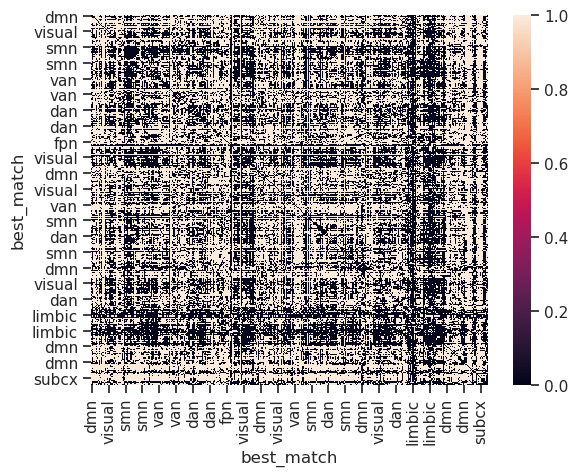

In [36]:
sns.heatmap(origpos_banda);

<Axes: xlabel='best_match', ylabel='best_match'>

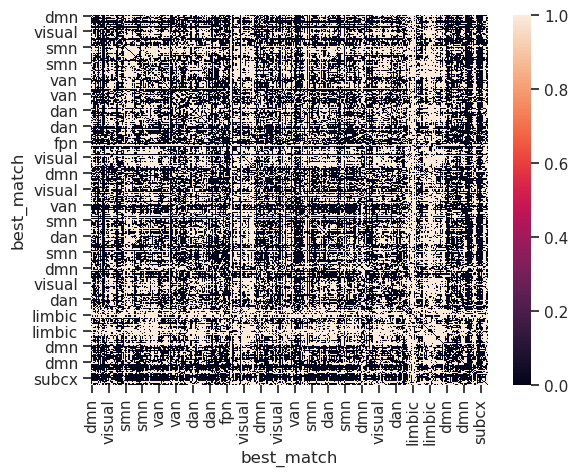

In [37]:
sns.heatmap(origneg_banda)

it's expected that origpos_banda and origneg_banda are a mirror version of eachother since defined based on banda spearman direction BUT haven't masked with ABCD mask yet

# keeping only nodes that were significant in ABCD

In [38]:
# posmask_352 = comb100 * origpos_banda

posmask_352 = origpos_banda.multiply(comb100) # banda positive mask
posmask_352.sum().sum()

372.0

<Axes: xlabel='best_match', ylabel='best_match'>

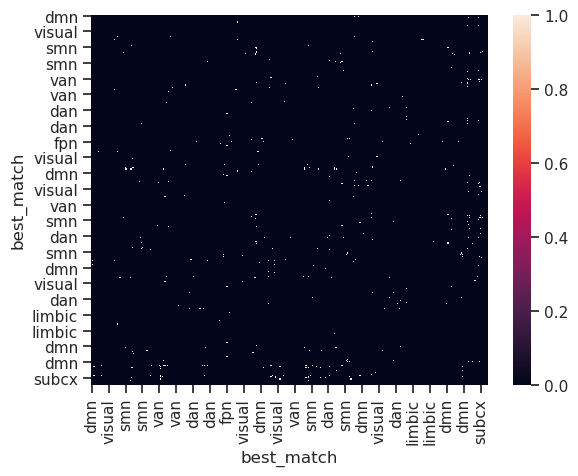

In [39]:
sns.heatmap(posmask_352)

In [40]:
# negmask_352 = comb100 * origneg_banda
negmask_352 = origneg_banda.multiply(comb100) # banda negative mask
negmask_352.sum().sum()

232.0

<Axes: xlabel='best_match', ylabel='best_match'>

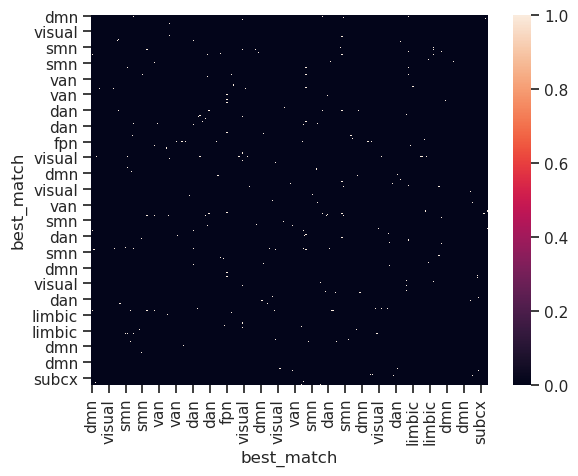

In [41]:
sns.heatmap(negmask_352)

<Axes: xlabel='best_match', ylabel='best_match'>

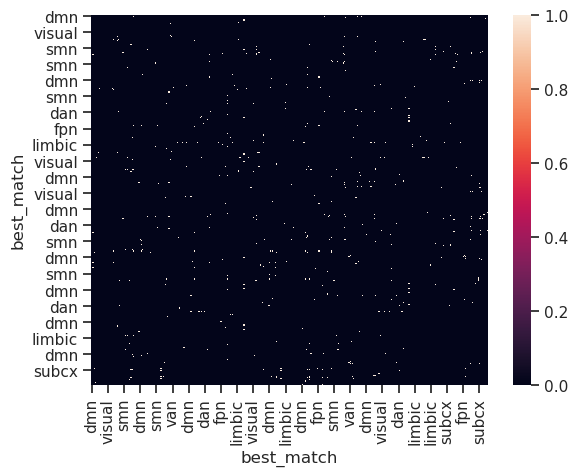

In [42]:
sns.heatmap(comb100_cleaned)

# reducing size

In [43]:
origpos_banda = pd.DataFrame(origpos_banda.values,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()
origneg_banda = pd.DataFrame(origneg_banda.values,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()

# # remove parcels that did not have any matching
drop_col1='none'
pos100_cleaned_banda=origpos_banda.drop(drop_col1, axis=1).drop(drop_col1, axis=0).copy()
neg100_cleaned_banda=origneg_banda.drop(drop_col1, axis=1).drop(drop_col1, axis=0).copy()
atlas_coords_cleaned = atlas_coords[atlas_coords[grab_col] != drop_col1]

drop_col2='cerebellum'
pos100_cleaned_banda=pos100_cleaned_banda.drop(drop_col2, axis=1).drop(drop_col2, axis=0).copy()
neg100_cleaned_banda=neg100_cleaned_banda.drop(drop_col2, axis=1).drop(drop_col2, axis=0).copy()
atlas_coords_cleaned = atlas_coords_cleaned[atlas_coords_cleaned[grab_col] != drop_col2]

In [44]:
posmask = comb100_cleaned * pos100_cleaned_banda # banda positive mask
posmask.sum().sum()

294.0

In [45]:
negmask = comb100_cleaned * neg100_cleaned_banda # banda negative mask
negmask.sum().sum()

208.0

In [46]:
posmask.sum().sum()+ negmask.sum().sum()

502.0

In [47]:
comb100_cleaned.sum().sum() # abcd

502.0

In [48]:
comb100_cleaned.sum().sum() /2

251.0

looks good since they need to match. the sum of the abds comb100 nodes needs to be the same as the sum of pos_banda + neg_banda  
now i have a pos and neg mask defined by the connectivity of the banda adolescents (NOT abcd children), but only for connections significant/derived from abcd children via cross-validation

In [1]:
# # defininng here only to change color easily
# def get_count_edge_by_network_cleaned(mask_pos, mask_neg, percent_thr, atlas_coords, plot_normed,which_grouping, which_order, grab_annot=True):
    
#     fs=30 #fontsize
 
#     masks = [mask_pos, mask_neg]
#     edges = [mask_pos, mask_neg]
#     edge_count_norm = [mask_pos, mask_neg]
#     for m,i in zip(masks, range(len(masks))):

#         # binarize by some threshold
#         m = np.where(m > percent_thr, 1, 0)  
#         # m = np.tril(m,0) #masking out the upper triangle but keeping the diagonalj (thouthg should already be passed as only lower triangle)

#         # check dimension of inputs
#         if m.shape[0] == m.shape[1]:
#             m = pd.DataFrame(m, index = atlas_coords[which_grouping], columns = atlas_coords[which_grouping])
#         elif m.shape[0] != m.shape[1]:
#             if m.shape[0] ==1 | m.shape[1] ==1:
#                 m = sp.spatial.distance.squareform(masks[m])
#                 m = pd.DataFrame(m, index = atlas_coords[which_grouping], columns = atlas_coords[which_grouping])
#             else:
#                 assert False,'check dimension of masks. should either be a square form or 1-dim vector'

#         # absolute count of edges per network
#         edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
#         edge_netnet_survived = edge_netnet_survived.groupby(which_grouping).sum() #aggregate rows
#         np.fill_diagonal(edge_netnet_survived.values, np.diag(edge_netnet_survived)/2) # dividing the diagonal by 2 because counts is dobled there (but only there! the triangles are ok)
#         # edge_netnet_survived = edge_netnet_survived/2 # because counting edges twice (upper and lower triangle, so need half of the counts)
#         edges[i] = edge_netnet_survived


#         # Normaliazed (Green et al., 2018, Nat Communication)
#         edge_tot_survived = edges[i].sum().sum()
#         numerator = edge_netnet_survived / edge_tot_survived

#         # denominator
#         edge_netnet_wb = np.ones((len(m), len(m)), int)
#         np.fill_diagonal(edge_netnet_wb,0) #removing diagonal because there are no edges going from one node to the same node
#         edge_netnet_wb = pd.DataFrame(edge_netnet_wb, index = atlas_coords[which_grouping], columns = atlas_coords[which_grouping])
#         edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns
#         edge_netnet_wb = edge_netnet_wb.groupby(which_grouping).sum() #aggregate rows
#         # edge_netnet_wb = edge_netnet_wb/2
#         np.fill_diagonal(edge_netnet_wb.values, np.diag(edge_netnet_wb)/2)
#         edge_tot_wb = (len(m) * (len(m)-1))/2 #shoudl be 30,135

#         denominator = (edge_netnet_wb/edge_tot_wb)/2

#         # contribution
#         contribution = numerator / denominator
#         edge_count_norm[i] = contribution
#         ### added
#         edge_count_norm[i][edge_count_norm[i] < 1] = -999 #np.nan #-999

#     # Grab values for outputs
#     edge_count = {}
#     edge_count['pos'] = edges[0]
#     edge_count['neg'] = edges[1]

#     edge_count_normed = {}
#     edge_count_normed['pos'] = edge_count_norm[0]
#     edge_count_normed['neg'] = edge_count_norm[1]

#     # PLOT
#     if plot_normed ==0:
#         masks = edges
#         mylegend = 'Absolute Count'

#     elif plot_normed ==1:
#         masks = edge_count_norm
#         mylegend = 'Normalized Count'
        
#     masks[0]=pd.DataFrame(masks[0], columns=which_order, index=which_order) #customize order
#     masks[1]=pd.DataFrame(masks[1], columns=which_order, index=which_order)
        
#     mask_triu_0 = np.triu(np.ones_like(masks[0], dtype=bool))
#     mask_triu_0[np.diag_indices_from(mask_triu_0)] = False #keeping diagonal

#     mask_triu_1 = np.triu(np.ones_like(masks[1], dtype=bool))
#     mask_triu_1[np.diag_indices_from(mask_triu_1)] = False #keeping diagonal

#     # show
#     mycmap_0 = sns.diverging_palette(240, 10, s=60, as_cmap=True)# using to plot combined
#     # mycmap_0 = sns.diverging_palette(145, 275, s=60, as_cmap=True) #or cmap = 'vlag'
#     mycmap_1 = sns.diverging_palette(275, 145, s=60, as_cmap=True)#or cmap = 'vlag_r'

#     f, (ax1, ax2) = plt.subplots(1,2, figsize=[20,10], constrained_layout=True)
#     g1 = sns.heatmap(masks[0], mask=mask_triu_0, cmap=mycmap_0, annot= grab_annot, center=0,square=True, linewidths=6, cbar_kws=dict(shrink=0.5), fmt='.1f', vmin = 0,ax=ax1);

#     ax1.set(xlabel='', ylabel = '');
#     ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=fs, rotation=60, ha='center')    
#     ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=fs, rotation = 0)
#     ax1.tick_params(left=False, bottom=False)
#     cbar = ax1.collections[0].colorbar
#     cbar.set_label(mylegend, fontsize=fs)
#     cbar.ax.tick_params(axis='y', labelrotation=0, labelsize=fs, pad = 0, labelleft=True, labelright=False, size = 0)
#    # cbar.set_ticks([-10])
#     # cbar.set_ticklabels([''])

#     g2 = sns.heatmap(masks[1], mask=mask_triu_1, cmap=mycmap_1, center=0,square=True,annot= grab_annot,  linewidths=6, cbar_kws=dict(shrink= 0.5), fmt='.1f', vmin = 0,ax=ax2);
#     ax2.set(xlabel='', ylabel = '');
#     ax2.tick_params(left=False, bottom=False)
#     ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=fs, rotation= 60, ha='center')    
#     ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=fs, rotation = 0);

#     cbar = ax2.collections[0].colorbar
#     cbar.set_label(mylegend, fontsize=fs)
#     cbar.ax.tick_params(axis='y', labelrotation=0, labelsize=fs, pad = 0, labelleft=True, labelright=False, size = 0)

#     return edge_count,  edge_count_normed, f, #edge_netnet_wb, edge_netnet_survived

### Combined mask . showing network. the edges that were common to both abcd and banda

/tmp/ipykernel_31689/1084896088.py:26: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_31689/1084896088.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_31689/1084896088.py:26: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_31689/1084896088.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns


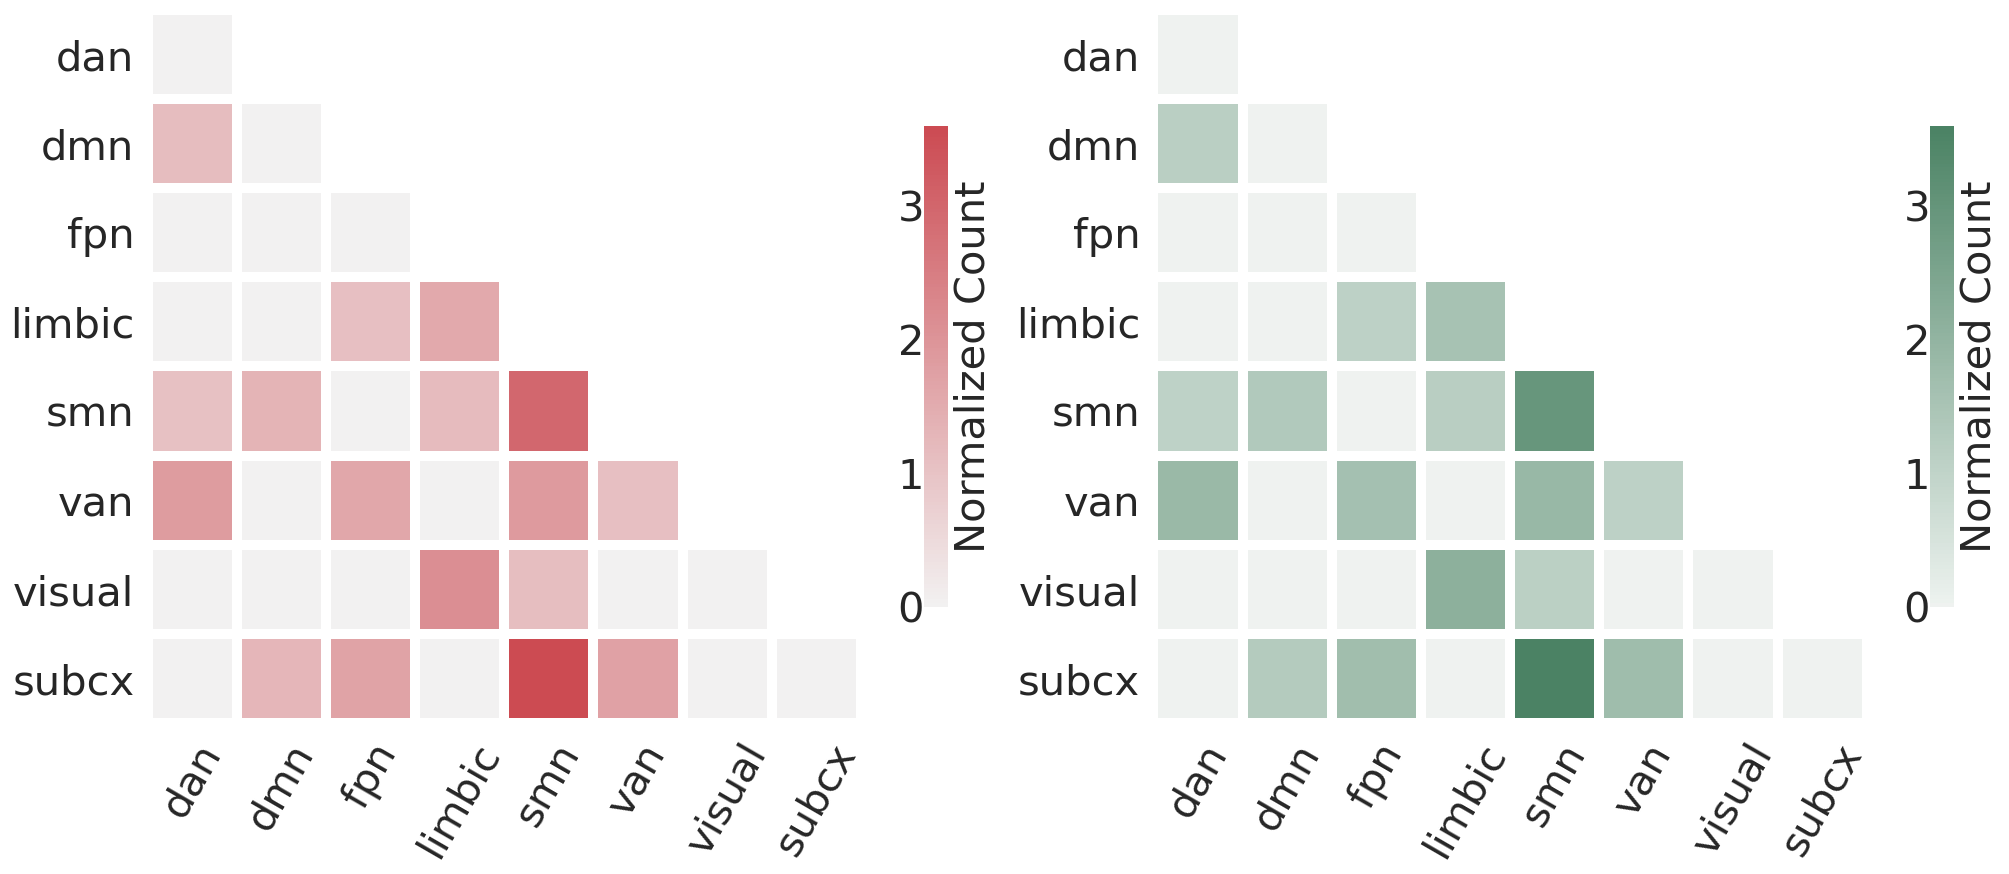

In [50]:
#tecnically I only need one but passing the same matrix twice to make it faster (and not have to modify function)
edge_count, edge_count_normed, fig = get_count_edge_by_network_cleaned(comb100_cleaned, comb100_cleaned, 0, atlas_coords_cleaned, plot_normed=1, which_grouping=grab_col, which_order=yeo_net_order, grab_annot=False)
#percent thre doesnt matter here since masks are already binariazed 

#save to file
g = fig.get_figure()
mysavefig(g,out_dir,'abcd_net_net_triangles_cleaned_abcdcombined_normed')

/tmp/ipykernel_31689/1084896088.py:26: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_31689/1084896088.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_31689/1084896088.py:26: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_31689/1084896088.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns


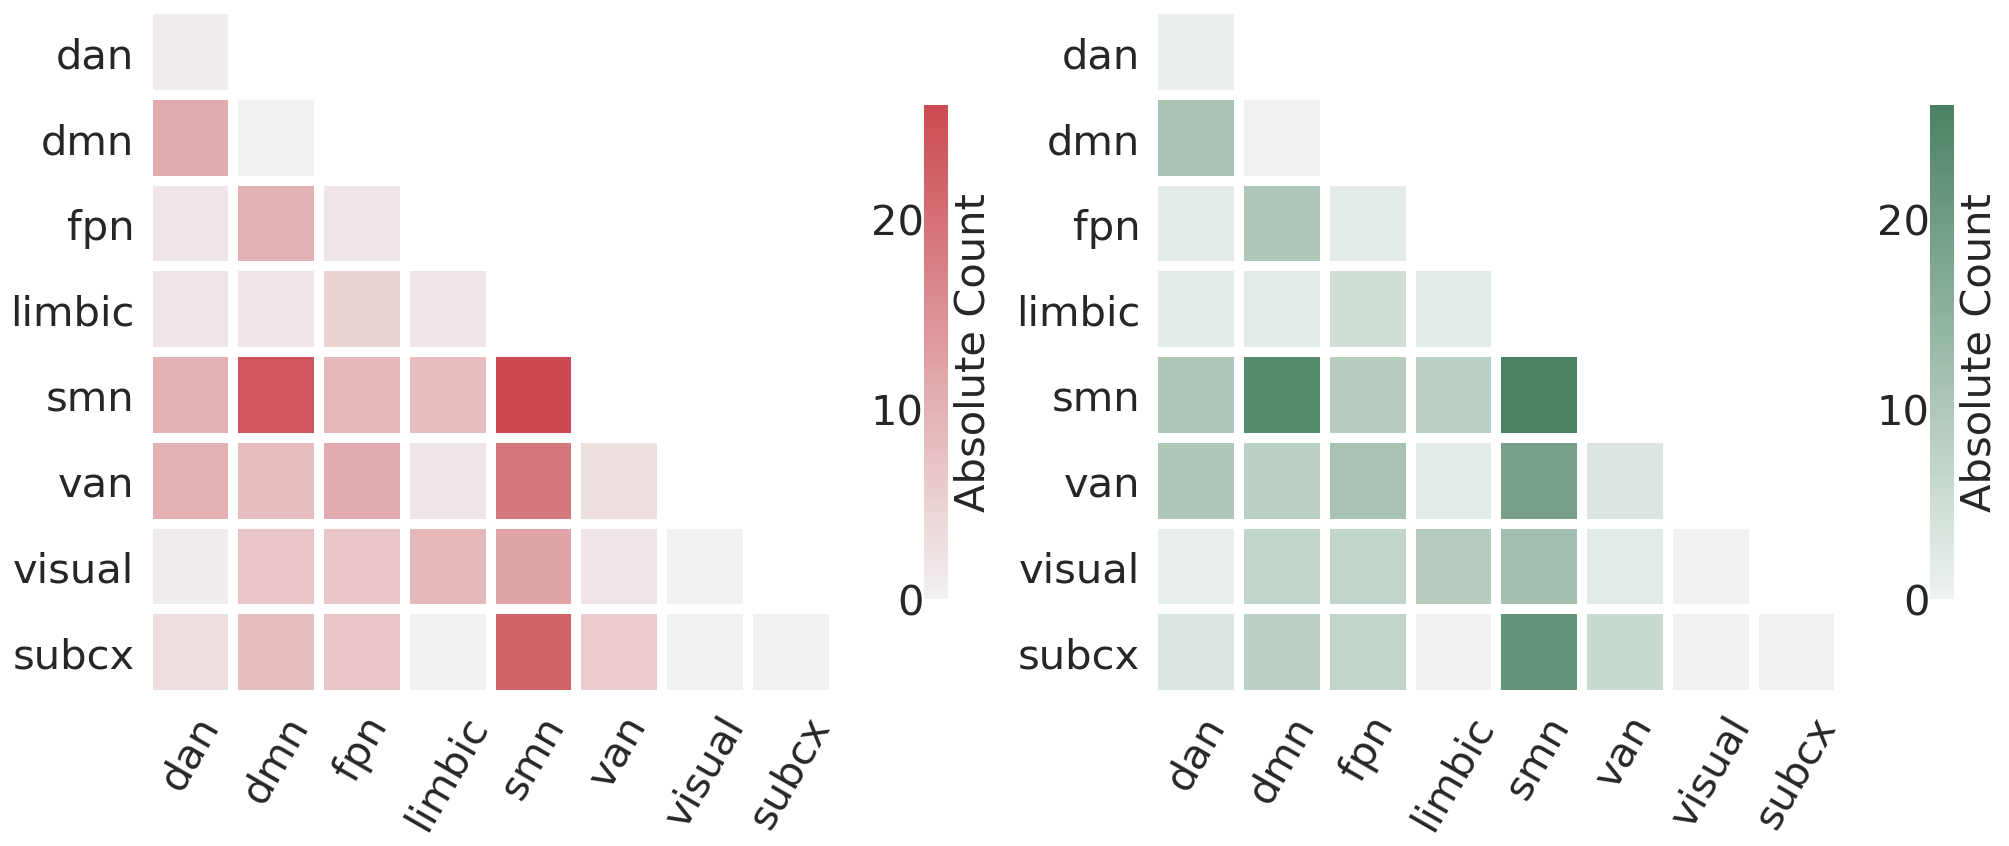

In [51]:
edge_count, edge_count_normed, fig = get_count_edge_by_network_cleaned(comb100_cleaned, comb100_cleaned, 0, atlas_coords_cleaned, plot_normed=0, which_grouping=grab_col, which_order=yeo_net_order, grab_annot=False)
#percent thre doesnt matter here since masks are already binariazed 

#save to file
g = fig.get_figure()
mysavefig(g,out_dir,'abcd_net_net_triangles_cleaned_abcdcombined_absolute')

# Plot FC 

In [55]:
def myfx_do_netnet_meanfc(mydata, myorder, netnetsum_nework, mycolorpalette, edge_count_position):

    # general parameters
    fs=50 #fontsize
    lw=5 #linewidth
    
    # create plots
    g = sns.catplot(data=mydata, x='variable',y ='value', height=10, aspect=2.5, palette = mycolorpalette, order=myorder, s = 8,  edgecolor="gray", linewidth=0.5)
    g.ax.axhline(0, color = 'black',linewidth=lw -2); #, linestyle=':'
    g.map_dataframe(sns.boxplot,'variable','value', order=myorder, linewidth=lw-2, zorder=100, width=0.75,
         showfliers=False, boxprops = {'facecolor':'none'}, color = 'black',
         ).set_xticklabels(fontsize=fs -5, rotation= 75, ha='right' 
         ).set_yticklabels(fontsize=fs -10
         ).set_xlabels(''
         ).set_ylabels('');

    g.ax.spines['left'].set_linewidth(lw)
    g.ax.spines['left'].set_color('black')
    g.ax.spines['bottom'].set_linewidth(lw)
    g.ax.tick_params(axis = 'x', width=lw, size = lw *2)
    g.ax.tick_params(axis = 'y', width=0)
    # g.ax.spines['bottom'].set_xticklabels(lw)
    g.ax.spines['bottom'].set_color('black');

    # PROPS = {
    #     'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    #     'medianprops':{'color':'green'},
    #     'whiskerprops':{'color':'blue'},
    #     'capprops':{'color':'yellow'}
    # }

    # add count of edges on top
    for i,n in enumerate(myorder):
        g.ax.annotate( (int(netnetsum_nework[n])   ), xy = (i,edge_count_position), horizontalalignment = 'center',fontsize=fs -20);
    return g

# Positive

In [56]:
grab_mask = posmask_352

# grab counts of net-net, and mask the upper triangle
tmp = pd.DataFrame(np.tril(edge_count['pos'],0), index=edge_count['pos'].index, columns=edge_count['pos'].columns)

# extract index-columns info of all non zero values
nonzero_net_net=dict([[i,tmp.loc[i].loc[lambda tmp: tmp.ne(0)].index.tolist()] for i in tmp.index])

# create list of index-colum, one per non zero value in a format that's 1 index and 1 column
netnet_pos =[]
for i in tmp.index:
    s=len(nonzero_net_net[i])
    for f in range(s):
        netnet_pos.append([i,nonzero_net_net[i][f]])
# netnet

In [57]:
# extract functional connectivity corresponding to the masks , from every participant
# also extract count of contributing edges per networks pair. this info should match that of the triangluar matrices
nodes_pos= {}
fc_by_net_pos = pd.DataFrame()
netnetsum_pos ={}

for pair in netnet_pos:
    net1 = pair[0]
    net2 = pair[1]
    label = ('-'.join(pair)).upper()
    label = label.replace('LIMBIC','Limbic').replace('VISUAL','Visual').replace('SUBCX','SubCx')
    nodes_pos[f'{label}'], fc_pos, netnetsum_pos[f'{label}'] = cpm_visual.get_fc_by_net_net(net1, net2, grab_mask, atlas_coords, connectomes_banda, grab_col)
    fc_by_net_pos[f'{label}'] = fc_pos
fc_by_net_pos.index = fc_by_net_pos.index.rename('participant_id')
# this gives both fc and nodes

In [58]:
fc_by_net2 = fc_by_net_pos.reset_index().copy()
tmp = pd.melt(fc_by_net2, id_vars=['participant_id']).copy()

In [87]:
tmp_pos = tmp
# tmp = tmp[(tmp['value'] > -2) & (tmp['value'] < 2)]

# tt = tmp_pos[(tmp_pos['participant_id'] != 'NDARINVMZG6CUGJ') &
#          (tmp_pos['participant_id'] != 'NDARINVZVNYXUNB') &
#          (tmp_pos['participant_id'] != 'NDARINVMZG6CUGJ') &
#          (tmp_pos['participant_id'] != 'NDARINV540M2VDX')]
tt = tmp_pos

In [60]:
def myfx_do_netnet_meanfc_tmp(mydata, myorder, netnetsum_nework, mycolorpalette, edge_count_position):

    # general parameters
    fs=30 #fontsize
    lw=5 #linewidth
    
    # create plots
    g = sns.catplot(data=mydata, y='variable',x ='value', height=5, aspect=1.5, palette = mycolorpalette, order=myorder, s = 8,  edgecolor="gray", linewidth=0.5)
    g.ax.axvline(0, color = 'black',linewidth=lw -2); #, linestyle=':'
    g.map_dataframe(sns.boxplot,'value','variable', order=myorder, linewidth=lw-2, zorder=100, width=0.75,
         showfliers=False, boxprops = {'facecolor':'none'}, color = 'black',
         ).set_xticklabels(fontsize=fs -5, rotation= 75, ha='right' 
         ).set_yticklabels(fontsize=fs -10
         ).set_xlabels(''
         ).set_ylabels('');

    g.ax.spines['left'].set_linewidth(lw)
    g.ax.spines['left'].set_color('black')
    g.ax.spines['bottom'].set_linewidth(lw)
    g.ax.tick_params(axis = 'x', width=lw, size = lw *2)
    g.ax.tick_params(axis = 'y', width=0)
    # g.ax.spines['bottom'].set_xticklabels(lw)
    g.ax.spines['bottom'].set_color('black');

    # PROPS = {
    #     'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    #     'medianprops':{'color':'green'},
    #     'whiskerprops':{'color':'blue'},
    #     'capprops':{'color':'yellow'}
    # }

    # add count of edges on top
    # for i,n in enumerate(myorder):
    #     g.ax.annotate( (int(netnetsum_nework[n])   ), xy = (i,edge_count_position), horizontalalignment = 'center',fontsize=fs -20);
    return g

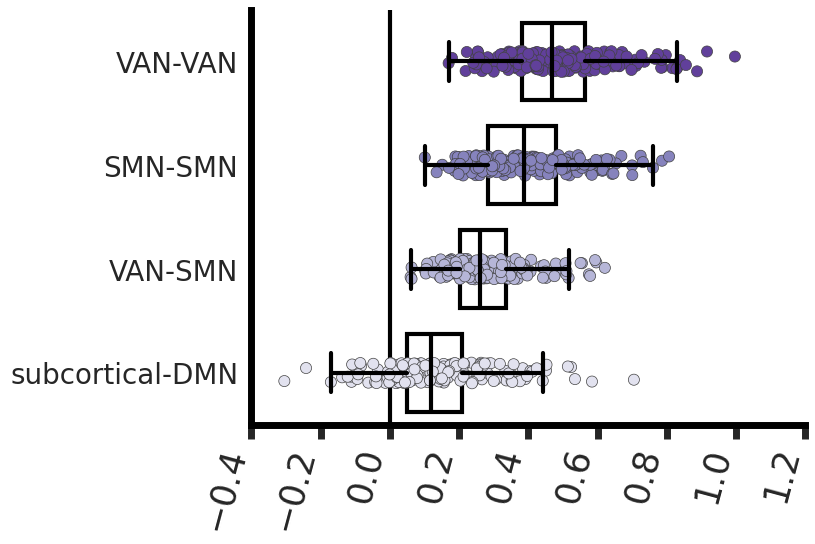

In [61]:
# customize order of results

myorder=tt['variable'].unique()

myorder = ['VAN-VAN', 'SMN-SMN', 'VAN-SMN','SubCx-DMN']
# myorder = ['VAN-VAN', 'SMN-SMN', 'Limbic-Limbic','DMN-DAN', 'Limbic-FPN',  'SMN-DAN', 'SMN-DMN','SMN-Limbic', 'SubCx-DMN','SubCx-FPN', 'SubCx-SMN', 'VAN-DAN', 'VAN-FPN','VAN-SMN', 'VAN-SubCx',  'Visual-SMN']

tt['variable']= tt['variable'].str.replace('SubCx','subcortical')
myorder = [item.replace('SubCx', 'subcortical') for item in myorder]
netnetsum_pos = {key.replace('SubCx', 'subcortical'): value for key, value in netnetsum_pos.items()}

#create fig
g = myfx_do_netnet_meanfc_tmp(tt, myorder, netnetsum_pos, 'Purples_r', 1.15);

#save to file
mysavefig(g,out_dir,'abcd_net_net_meanFC_boxplots_positiveBANDANetwork')

In [88]:
tt = tt.merge(final_banda.reset_index()[['participant_id', 'group']], on='participant_id', how='left')


# Negative

In [102]:
grab_mask = negmask_352

# grab counts of net-net, and mask the upper triangle
tmp = pd.DataFrame(np.tril(edge_count['neg'],0), index=edge_count['neg'].index, columns=edge_count['neg'].columns)

# extract index-columns info of all non zero values
nonzero_net_net=dict([[i,tmp.loc[i].loc[lambda tmp: tmp.ne(0)].index.tolist()] for i in tmp.index])

# create list of index-colum, one per non zero value in a format that's 1 index and 1 column
netnet_neg =[]
for i in tmp.index:
    s=len(nonzero_net_net[i])
    for f in range(s):
        netnet_neg.append([i,nonzero_net_net[i][f]])
# netnet

In [103]:
# extract functional connectivity corresponding to the masks , from every participant
# also extract count of contributing edges per networks pair. this info should match that of the triangluar matrices
nodes_neg= {}
fc_by_net_neg = pd.DataFrame()
netnetsum_neg ={}

for pair in netnet_neg:
    net1 = pair[0]
    net2 = pair[1]
    label = ('-'.join(pair)).upper()
    label = label.replace('LIMBIC','Limbic').replace('VISUAL','Visual').replace('SUBCX','SubCx')
    nodes_neg[f'{label}'], fc_neg, netnetsum_neg[f'{label}'] = cpm_visual.get_fc_by_net_net(net1, net2, grab_mask, atlas_coords, connectomes_banda, grab_col)
    fc_by_net_neg[f'{label}'] = fc_neg
fc_by_net_neg.index = fc_by_net_neg.index.rename('participant_id')
# this gives both fc and nodes

In [104]:
fc_by_net2 = fc_by_net_neg.reset_index().copy()
# fc_by_net2 = fc_by_net2[fc_by_net2['participant_id'] != 'NDARINVMZG6CUGJ']
# fc_by_net2['group']=all_behave.loc[behave.index, "group"].values
# fc_by_net2['group2']=all_behave.loc[behave.index, "group2"].values
# fc_by_net2['meds']=all_behave.loc[behave.index, "meds"].values
# tmp = pd.melt(fc_by_net2, id_vars=['participant_id'], value_vars=fc_by_net2.columns).copy()
tmp = pd.melt(fc_by_net2, id_vars=['participant_id']).copy()

In [105]:
tmp_neg = tmp
# tmp = tmp[(tmp['value'] > -2) & (tmp['value'] < 2)]

# tt = tmp_neg[(tmp_neg['participant_id'] != 'NDARINVMZG6CUGJ') &
#          (tmp_neg['participant_id'] != 'NDARINVZVNYXUNB') &
#          (tmp_neg['participant_id'] != 'NDARINVMZG6CUGJ') &
#          (tmp_neg['participant_id'] != 'NDARINV540M2VDX')]
tt = tmp_neg

In [107]:
tt = tt.merge(final_banda.reset_index()[['participant_id', 'group']], on='participant_id', how='left')


AttributeError: 'Axes' object has no attribute 'savefig'

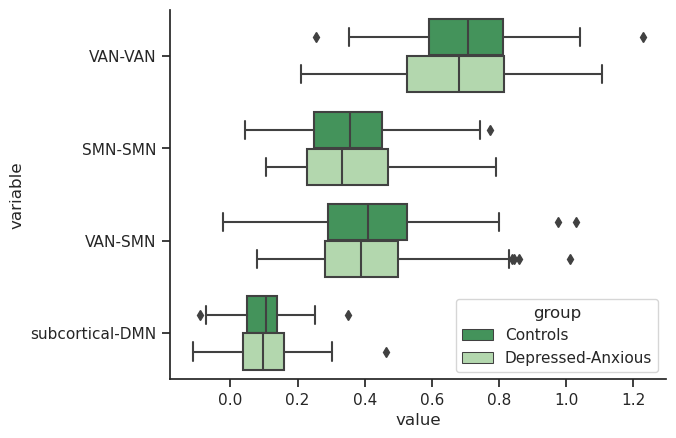

In [108]:
# customize order of results

myorder=tt['variable'].unique()
# myorder = ['VAN-VAN', 'SMN-SMN','Limbic-Limbic','DMN-DAN', 'FPN-DMN', 'Limbic-DAN', 'Limbic-FPN', 
#        'SMN-DAN', 'SMN-DMN', 'SMN-FPN', 'SMN-Limbic', 
#        'SubCx-DAN', 'SubCx-DMN', 'SubCx-FPN', 'SubCx-SMN', 'VAN-DAN',
#        'VAN-DMN', 'VAN-FPN', 'VAN-Limbic', 'VAN-SMN', 'VAN-SubCx',
#        'Visual-DAN', 'Visual-DMN', 'Visual-FPN',
#        'Visual-Limbic', 'Visual-SMN']

myorder = ['VAN-VAN', 'SMN-SMN', 'VAN-SMN','SubCx-DMN' ]

tt['variable']= tt['variable'].str.replace('SubCx','subcortical')
myorder = [item.replace('SubCx', 'subcortical') for item in myorder]
netnetsum_neg = {key.replace('SubCx', 'subcortical'): value for key, value in netnetsum_neg.items()}

#create fig
g = myfx_do_netnet_meanfc_tmp(tt, myorder, netnetsum_neg, 'Greens_r', 1.25);

#save to file
mysavefig(g,out_dir,'abcd_net_net_meanFC_boxplots_negativeBANDANetwork')

# SUBCORTICAL

In [143]:
def get_count_edge_by_network_cleaned_subcx(mask_pos, mask_neg, percent_thr, atlas_coords, plot_normed,which_grouping, which_order, grab_annot=True):
    
    fs=20 #fontsize2
    masks = [mask_pos, mask_neg]
    edges = [mask_pos, mask_neg]
    edge_count_norm = [mask_pos, mask_neg]
    for m,i in zip(masks, range(len(masks))):

        # binarize by some threshold
        m = np.where(m > percent_thr, 1, 0)  
        # m = np.tril(m,0) #masking out the upper triangle but keeping the diagonalj (thouthg should already be passed as only lower triangle)

        # check dimension of inputs
        if m.shape[0] == m.shape[1]:
            m = pd.DataFrame(m, index = atlas_coords[which_grouping], columns = atlas_coords[which_grouping])
        elif m.shape[0] != m.shape[1]:
            if m.shape[0] ==1 | m.shape[1] ==1:
                m = sp.spatial.distance.squareform(masks[m])
                m = pd.DataFrame(m, index = atlas_coords[which_grouping], columns = atlas_coords[which_grouping])
            else:
                assert False,'check dimension of masks. should either be a square form or 1-dim vector'

        # absolute count of edges per network
        edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
        edge_netnet_survived = edge_netnet_survived.groupby(which_grouping).sum() #aggregate rows
        np.fill_diagonal(edge_netnet_survived.values, np.diag(edge_netnet_survived)/2) # dividing the diagonal by 2 because counts is dobled there (but only there! the triangles are ok)
        # edge_netnet_survived = edge_netnet_survived/2 # because counting edges twice (upper and lower triangle, so need half of the counts)
        edges[i] = edge_netnet_survived


        # Normaliazed (Green et al., 2018, Nat Communication)
        edge_tot_survived = edges[i].sum().sum()
        numerator = edge_netnet_survived / edge_tot_survived

        # denominator
        edge_netnet_wb = np.ones((len(m), len(m)), int)
        np.fill_diagonal(edge_netnet_wb,0) #removing diagonal because there are no edges going from one node to the same node
        edge_netnet_wb = pd.DataFrame(edge_netnet_wb, index = atlas_coords[which_grouping], columns = atlas_coords[which_grouping])
        edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns
        edge_netnet_wb = edge_netnet_wb.groupby(which_grouping).sum() #aggregate rows
        # edge_netnet_wb = edge_netnet_wb/2
        np.fill_diagonal(edge_netnet_wb.values, np.diag(edge_netnet_wb)/2)
        edge_tot_wb = (len(m) * (len(m)-1))/2 #shoudl be 30,135

        denominator = (edge_netnet_wb/edge_tot_wb)/2

        # contribution
        contribution = numerator / denominator
        edge_count_norm[i] = contribution
        ### added
        edge_count_norm[i][edge_count_norm[i] < 1] = -999 #np.nan #-999

    # Grab values for outputs
    edge_count = {}
    edge_count['pos'] = edges[0]
    edge_count['neg'] = edges[1]

    edge_count_normed = {}
    edge_count_normed['pos'] = edge_count_norm[0]
    edge_count_normed['neg'] = edge_count_norm[1]

    # PLOT
    if plot_normed ==0:
        masks = edges
        cbar_title = 'Absolute Count'

    elif plot_normed ==1:
        masks = edge_count_norm
        cbar_title = 'Normalized Count'        
    
    #customize dataframe
    dict_yeo_caps ={"dan":"DAN","dmn": "DMN", "fpn":"FPN","limbic":"LIMBIC",
                                      "smn":"SMN","van":"VAN","visual":"VISUAL"}
    masks[0]=pd.DataFrame(masks[0], columns=which_order, index=which_order) #customize order
    
    masks[0].columns = masks[0].columns.str.lower()
    masks[0].index = masks[0].index.str.lower()
    
    masks[0] = masks[0].rename(index=dict_yeo_caps)
    masks[0] = masks[0].rename(columns=dict_yeo_caps)
    
    
    masks[1]=pd.DataFrame(masks[1], columns=which_order, index=which_order)
    masks[1].columns = masks[1].columns.str.lower()
    masks[1].index = masks[1].index.str.lower()
    
    masks[1] = masks[1].rename(index=dict_yeo_caps)
    masks[1] = masks[1].rename(columns=dict_yeo_caps)
    
    mask_triu_0 = np.triu(np.ones_like(masks[0], dtype=bool))
    mask_triu_0[np.diag_indices_from(mask_triu_0)] = False #keeping diagonal

    mask_triu_1 = np.triu(np.ones_like(masks[1], dtype=bool))
    mask_triu_1[np.diag_indices_from(mask_triu_1)] = False #keeping diagonal 

    # show
    # mycmap_0 = sns.diverging_palette(145, 275, s=60, as_cmap=True) #or cmap = 'vlag'
    mycmap_0 = sns.diverging_palette(240, 10, s=60, as_cmap=True)# using to plot combined

    mycmap_1 = sns.diverging_palette(275, 145, s=60, as_cmap=True)#or cmap = 'vlag_r'

    f, (ax1, ax2) = plt.subplots(1,2, figsize=[20,10], constrained_layout=True)
    g1 = sns.heatmap(masks[0], mask=mask_triu_0, cmap=mycmap_0, annot= grab_annot, center=0,square=True, linewidths=6, cbar_kws=dict(shrink=0.4), fmt='.1f', vmin = 0,ax=ax1);

    ax1.set(xlabel='', ylabel = '');
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=fs, rotation=60, ha='right')    
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=fs, rotation = 0)
    ax1.tick_params(left=False, bottom=False)
    cbar = ax1.collections[0].colorbar
    cbar.set_label(cbar_title, fontsize=fs)
    cbar.ax.tick_params(axis='y', labelrotation=0, labelsize=fs, pad = 0, labelleft=True, labelright=False, size = 0)
   # cbar.set_ticks([-10])
    # cbar.set_ticklabels([''])

    g2 = sns.heatmap(masks[1], mask=mask_triu_1, cmap=mycmap_1, center=0,square=True,annot= grab_annot,  linewidths=6, cbar_kws=dict(shrink= 0.4), fmt='.1f', vmin = 0,ax=ax2);
    ax2.set(xlabel='', ylabel = '');
    ax2.tick_params(left=False, bottom=False)
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=fs, rotation= 60, ha='right')    
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=fs, rotation = 0);

    cbar = ax2.collections[0].colorbar
    cbar.set_label(cbar_title, fontsize=fs)
    cbar.ax.tick_params(axis='y', labelrotation=0, labelsize=fs, pad = 0, labelleft=True, labelright=False, size = 0)

    return edge_count, edge_netnet_survived, f
# return edge_netnet_wb, edge_netnet_survived, f

/tmp/ipykernel_29771/2191180430.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_29771/2191180430.py:39: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_29771/2191180430.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_29771/2191180430.py:39: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns


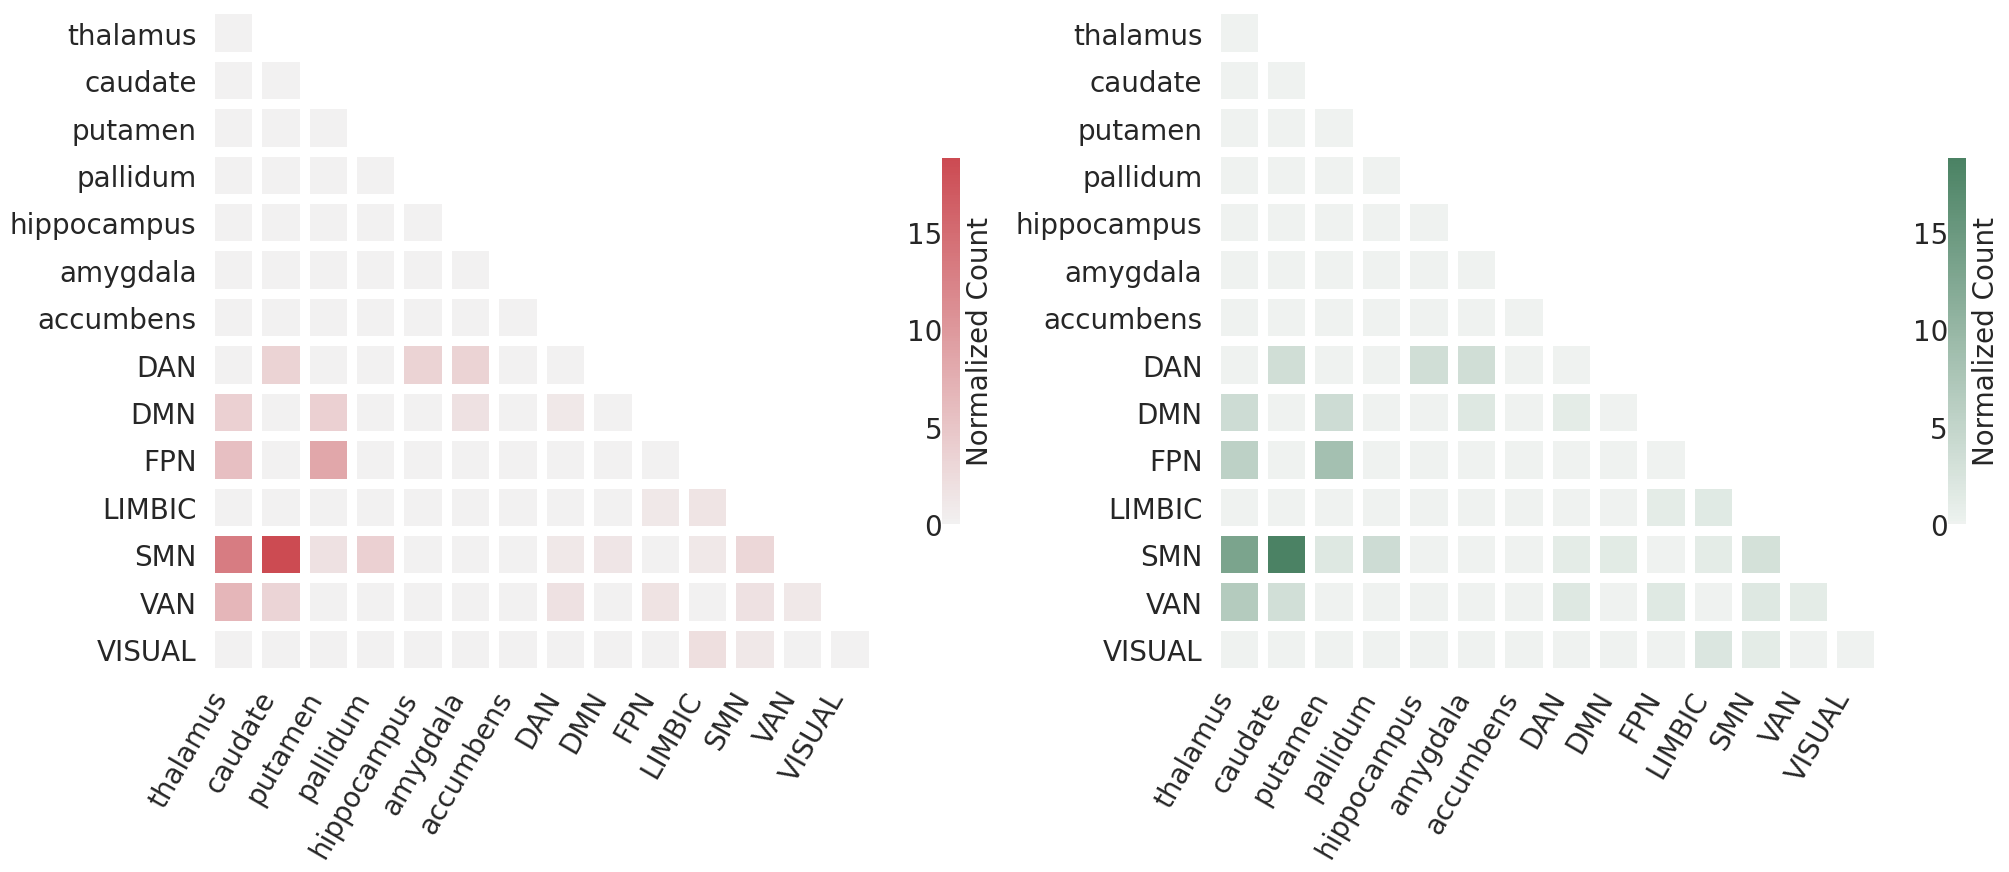

In [108]:
# again passing the same matrix twice(so they are identical in the output), i only need one 
#order in which networks will be listed in triangular matrices
subcx_order=['Thalamus', 'Caudate', 'Putamen', 'Pallidum', 
       'Hippocampus', 'Amygdala', 'Accumbens', 'dan','dmn', 'fpn', 'limbic','smn', 'van', 'visual']

edge_count, edge_count_normed, fig = get_count_edge_by_network_cleaned_subcx(comb100_cleaned, comb100_cleaned, 0, atlas_coords_cleaned, plot_normed=1, which_grouping='best_match_subcx', which_order=subcx_order, grab_annot=False)
#save to file
g = fig.get_figure()
mysavefig(g,out_dir,'banda_net_net_triangles_subcx_normed') 

/tmp/ipykernel_29771/2191180430.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_29771/2191180430.py:39: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_29771/2191180430.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_survived = m.groupby(m.columns, axis=1).sum() #aggregate columns
/tmp/ipykernel_29771/2191180430.py:39: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  edge_netnet_wb = edge_netnet_wb.groupby(edge_netnet_wb.columns, axis=1).sum() #aggregate columns


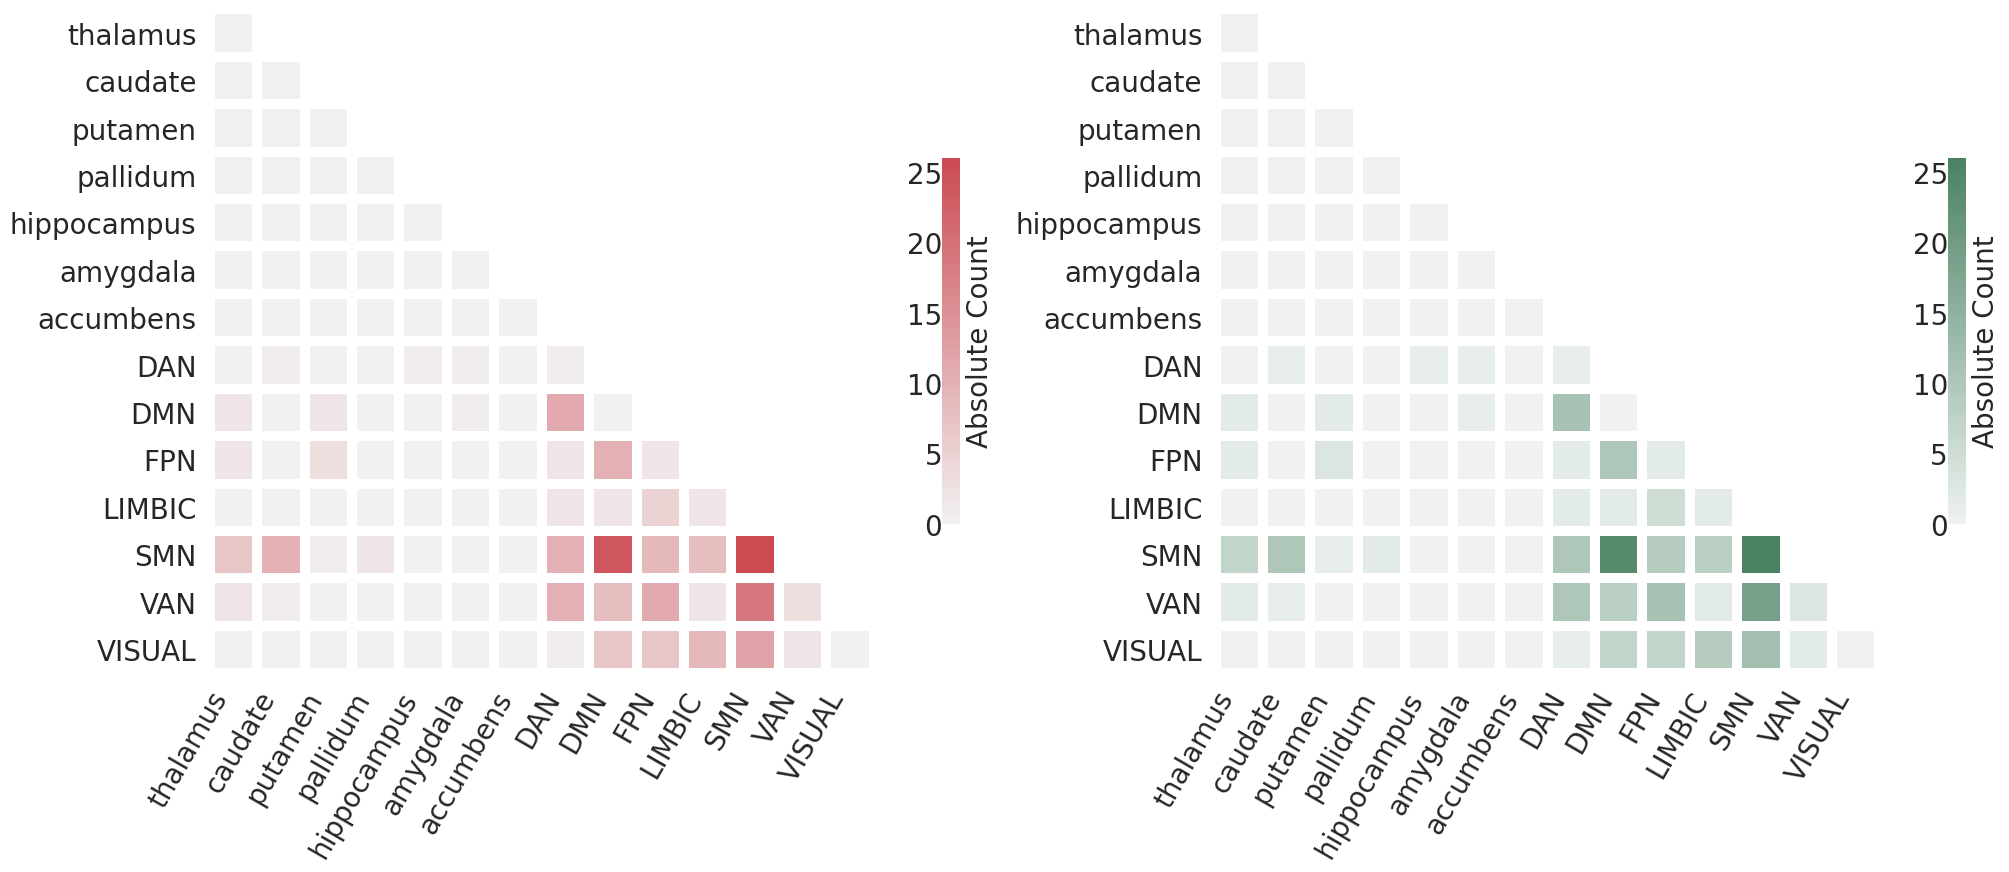

In [107]:
#order in which networks will be listed in triangular matrices
subcx_order=['Thalamus', 'Caudate', 'Putamen', 'Pallidum', 
       'Hippocampus', 'Amygdala', 'Accumbens', 'dan','dmn', 'fpn', 'limbic','smn', 'van', 'visual']

edge_count, edge_count_normed, fig = get_count_edge_by_network_cleaned_subcx(comb100_cleaned, comb100_cleaned, 0, atlas_coords_cleaned, plot_normed=0, which_grouping='best_match_subcx', which_order=subcx_order, grab_annot=False)
#save to file
g = fig.get_figure()
mysavefig(g,out_dir,'banda_net_net_triangles_subcx_absolute') 

# FC

In [132]:
def myfx_do_netnet_meanfc_subcx(mydata, myorder, netnetsum_nework, mycolorpalette, edge_count_position):

    # general parameters
    fs=25 #fontsize
    lw=2 #linewidth

    sns.set(rc={'figure.figsize':(10,5), "axes.spines.right": False, "axes.spines.top": False}, style="ticks") #, font_scale=1.5, style='whitegrid'

    # create plots
    g = sns.boxplot(data=mydata, x='variable',y ='value', palette = mycolorpalette, order=myorder, linewidth=1, zorder=100, whis=1, showfliers=False) 
    g.set_xticklabels(g.get_xticklabels(), fontsize=fs -10, rotation= 90, ha='center' )

    g.axhline(0, color = 'black',linewidth=lw, linestyle=':' ); #, linestyle=':'

    g.spines['left'].set_linewidth(lw)
    g.spines['left'].set_color('black')
    g.spines['bottom'].set_linewidth(lw)
    g.tick_params(axis = 'x', width=lw, size = lw *2)
    g.tick_params(axis = 'y', width=0)
    g.spines['bottom'].set_color('black');

    # add count of edges on top
    for i,n in enumerate(myorder):
        g.annotate( (int(netnetsum_nework[n])   ), xy = (i,edge_count_position), horizontalalignment = 'center',fontsize=fs -15);

    print('plot looks ugly here but renders well once exported')
    return g

In [133]:
grab_col='best_match_subcx'
origpos_banda_subcx = pd.DataFrame(origpos_banda.values,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()
origneg_banda_subcx = pd.DataFrame(origneg_banda.values,index = atlas_coords[grab_col], columns = atlas_coords[grab_col]).copy()

pos100_cleaned_banda_subcx = origpos_banda_subcx
neg100_cleaned_banda_subcx = origneg_banda_subcx

# Negative

In [135]:
grab_mask = neg100_cleaned_banda_subcx

# grab counts of net-net, and mask the upper triangle
tmp = pd.DataFrame(np.tril(edge_count['neg'],0), index=edge_count['neg'].index, columns=edge_count['neg'].columns)

# extract index-columns info of all non zero values
nonzero_net_net=dict([[i,tmp.loc[i].loc[lambda tmp: tmp.ne(0)].index.tolist()] for i in tmp.index])

# create list of index-colum, one per non zero value in a format that's 1 index and 1 column
netnet_neg =[]
for i in tmp.index:
    s=len(nonzero_net_net[i])
    for f in range(s):
        netnet_neg.append([i,nonzero_net_net[i][f]])
# netnet_neg

In [136]:
grab_col='best_match_subcx'
# extract functional connectivity corresponding to the masks , from every participant
# also extract count of contributing edges per networks pair. this info should match that of the triangluar matrices
nodes_neg= {}
fc_by_net_neg = pd.DataFrame()
netnetsum_neg ={}
for pair in netnet_neg:
    net1 = pair[0]
    net2 = pair[1]
    label = ('-'.join(pair)).upper()
    label = label.replace('LIMBIC','Limbic').replace('VISUAL','Visual').replace('SUBCX','SubCx')
    nodes_neg[f'{label}'], fc_neg, netnetsum_neg[f'{label}'] = cpm_visual.get_fc_by_net_net(net1, net2, grab_mask, atlas_coords, connectomes_banda, grab_col)
    fc_by_net_neg[f'{label}'] = fc_neg
fc_by_net_neg.index = fc_by_net_neg.index.rename('participant_id')
# this gives both fc and nodes

In [137]:
fc_by_net2 = fc_by_net_neg.reset_index().copy()
# fc_by_net2 = fc_by_net2[fc_by_net2['participant_id'] != 'NDARINVMZG6CUGJ']
# fc_by_net2['group']=all_behave.loc[behave.index, "group"].values
# fc_by_net2['group2']=all_behave.loc[behave.index, "group2"].values
# fc_by_net2['meds']=all_behave.loc[behave.index, "meds"].values
# tmp = pd.melt(fc_by_net2, id_vars=['participant_id'], value_vars=fc_by_net2.columns).copy()
tmp = pd.melt(fc_by_net2, id_vars=['participant_id']).copy()

tmp_neg = tmp
# tmp = tmp[(tmp['value'] > -1) & (tmp['value'] < 1)]
# tt = tmp_neg[(tmp_neg['participant_id'] != 'NDARINVMZG6CUGJ') &
#          (tmp_neg['participant_id'] != 'NDARINVZVNYXUNB') &
#          (tmp_neg['participant_id'] != 'NDARINVMZG6CUGJ') &
#          (tmp_neg['participant_id'] != 'NDARINV540M2VDX')]
tt = tmp_neg

plot looks ugly here but renders well once exported


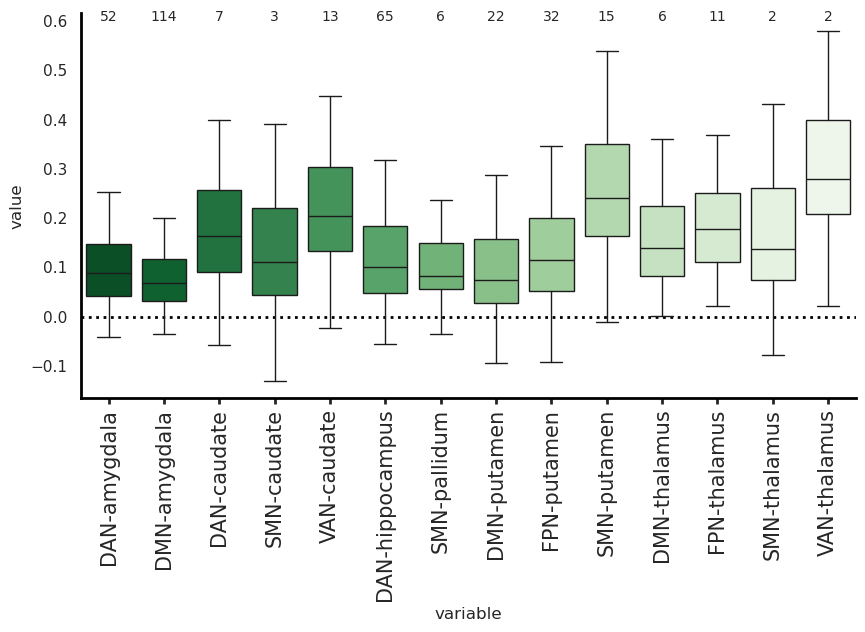

In [140]:
# customize order of results
# myorder=tmp['variable'].unique()

# tt['variable']=tt['variable'].str.replace('DIENCEPHALON_VENTRAL','DIENCEPHALON') 
tt['variable']=tt['variable'].str.replace('DIENCEPHALON_VENTRAL','DIENCEPHALON').str.replace('CAUDATE','caudate').str.replace('ACCUMBENS','accumbens').str.replace('DIENCEPHALON','diencephalon').str.replace('PUTAMEN','putamen').str.replace('THALAMUS','thalamus').str.replace('PALLIDUM','pallidum').str.replace('AMYGDALA','amygdala').str.replace('HIPPOCAMPUS','hippocampus')

nns_neg = netnetsum_neg

# nns_neg = {k.replace('DIENCEPHALON_VENTRAL','DIENCEPHALON'):v for k,v in nns_neg.items()}
nns_neg = {k.replace('DIENCEPHALON_VENTRAL','DIENCEPHALON').replace('CAUDATE','caudate').replace('ACCUMBENS','accumbens').replace('DIENCEPHALON','diencephalon').replace('PUTAMEN','putamen').replace('THALAMUS','thalamus').replace('PALLIDUM','pallidum').replace('AMYGDALA','amygdala').replace('HIPPOCAMPUS','hippocampus'):v for k,v in nns_neg.items()}

# myorder=tt['variable'].unique()
subcx_regions = ['caudate', 'accumbens', 'putamen', 'thalamus', 'pallidum', 'amygdala', 'hippocampus']

# subcx_regions = ['CAUDATE', 'ACCUMBENS', 'PUTAMEN', 'THALAMUS', 'PALLIDUM', 'AMYGDALA', 'HIPPOCAMPUS']
exclude = ['SubCx','BRAINSTEM','DIENCEPHALON']

myorder=tt['variable'].unique()
myorder = [
    item for item in myorder 
    if not any(ex in item for ex in exclude) and any(region in item for region in subcx_regions)
]

# re order alphabetically based on the subcx region
myorder = sorted(myorder, key=lambda x: x.split('-')[1])


#create fig
g = myfx_do_netnet_meanfc_subcx(tt, myorder, nns_neg, 'Greens_r',0.6);

#save to file
# mysavefig(g,out_dir,'banda_net_net_meanFC_boxplots_negativeNetwork_subcx')

# Positive

sometihng is wrong watch out

In [141]:
grab_mask = pos100_cleaned_banda_subcx

# grab counts of net-net, and mask the upper triangle
tmp = pd.DataFrame(np.tril(edge_count['pos'],0), index=edge_count['pos'].index, columns=edge_count['pos'].columns)

# extract index-columns info of all non zero values
nonzero_net_net=dict([[i,tmp.loc[i].loc[lambda tmp: tmp.ne(0)].index.tolist()] for i in tmp.index])

# create list of index-colum, one per non zero value in a format that's 1 index and 1 column
netnet_pos =[]
for i in tmp.index:
    s=len(nonzero_net_net[i])
    for f in range(s):
        netnet_pos.append([i,nonzero_net_net[i][f]])
# netnet_pos

In [142]:
grab_col='best_match_subcx'
# extract functional connectivity corresponding to the masks , from every participant
# also extract count of contributing edges per networks pair. this info should match that of the triangluar matrices
nodes_pos= {}
fc_by_net_pos = pd.DataFrame()
netnetsum_pos ={}
for pair in netnet_pos:
    net1 = pair[0]
    net2 = pair[1]
    label = ('-'.join(pair)).upper()
    label = label.replace('LIMBIC','Limbic').replace('VISUAL','Visual').replace('SUBCX','SubCx')
    nodes_pos[f'{label}'], fc_pos, netnetsum_pos[f'{label}'] = cpm_visual.get_fc_by_net_net(net1, net2, grab_mask, atlas_coords, connectomes_banda, grab_col)
    fc_by_net_pos[f'{label}'] = fc_pos
fc_by_net_pos.index = fc_by_net_pos.index.rename('participant_id')
# this gives both fc and nodes

In [143]:
fc_by_net2 = fc_by_net_pos.reset_index().copy()
# fc_by_net2 = fc_by_net2[fc_by_net2['participant_id'] != 'NDARINVMZG6CUGJ']
# fc_by_net2['group']=all_behave.loc[behave.index, "group"].values
# fc_by_net2['group2']=all_behave.loc[behave.index, "group2"].values
# fc_by_net2['meds']=all_behave.loc[behave.index, "meds"].values
# tmp = pd.melt(fc_by_net2, id_vars=['participant_id'], value_vars=fc_by_net2.columns).copy()
tmp = pd.melt(fc_by_net2, id_vars=['participant_id']).copy()

tmp_pos = tmp
# tmp = tmp[(tmp['value'] > -1) & (tmp['value'] < 1)]
# tt = tmp_pos[(tmp_pos['participant_id'] != 'NDARINVMZG6CUGJ') &
#          (tmp_pos['participant_id'] != 'NDARINVZVNYXUNB') &
#          (tmp_pos['participant_id'] != 'NDARINVMZG6CUGJ') &
#          (tmp_pos['participant_id'] != 'NDARINV540M2VDX')]
tt = tmp_pos

grab only some

In [144]:
# # subcx_regions = ['CAUDATE', 'ACCUMBENS', 'PUTAMEN', 'THALAMUS', 'PALLIDUM', 'AMYGDALA', 'HIPPOCAMPUS']
# subcx_regions = ['caudate', 'accumbens', 'putamen', 'thalamus', 'pallidum', 'amygdala', 'hippocampus']
# exclude = ['SubCx','BRAINSTEM','DIENCEPHALON']

# # myorder=tt['variable'].unique()
# myorder = [
#     item for item in myorder 
#     if not any(ex in item for ex in exclude) and any(region in item for region in subcx_regions)
# ]
# myorder

plot looks ugly here but renders well once exported


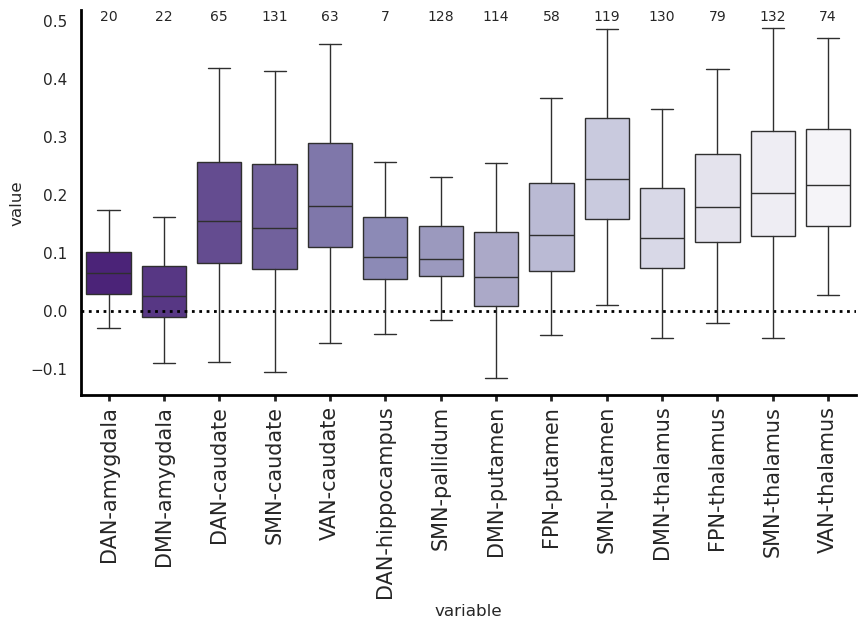

In [145]:
# customize order of results
# myorder=tmp['variable'].unique()

# tt['variable']=tt['variable'].str.replace('DIENCEPHALON_VENTRAL','DIENCEPHALON') 
tt['variable']=tt['variable'].str.replace('DIENCEPHALON_VENTRAL','DIENCEPHALON').str.replace('CAUDATE','caudate').str.replace('ACCUMBENS','accumbens').str.replace('DIENCEPHALON','diencephalon').str.replace('PUTAMEN','putamen').str.replace('THALAMUS','thalamus').str.replace('PALLIDUM','pallidum').str.replace('AMYGDALA','amygdala').str.replace('HIPPOCAMPUS','hippocampus')

nns_pos = netnetsum_pos

# nns_pos = {k.replace('DIENCEPHALON_VENTRAL','DIENCEPHALON'):v for k,v in nns_pos.items()}
nns_pos = {k.replace('DIENCEPHALON_VENTRAL','DIENCEPHALON').replace('CAUDATE','caudate').replace('ACCUMBENS','accumbens').replace('DIENCEPHALON','diencephalon').replace('PUTAMEN','putamen').replace('THALAMUS','thalamus').replace('PALLIDUM','pallidum').replace('AMYGDALA','amygdala').replace('HIPPOCAMPUS','hippocampus'):v for k,v in nns_pos.items()}

# myorder=tt['variable'].unique()
subcx_regions = ['caudate', 'accumbens', 'putamen', 'thalamus', 'pallidum', 'amygdala', 'hippocampus']

# subcx_regions = ['CAUDATE', 'ACCUMBENS', 'PUTAMEN', 'THALAMUS', 'PALLIDUM', 'AMYGDALA', 'HIPPOCAMPUS']
exclude = ['SubCx','BRAINSTEM','DIENCEPHALON']

myorder=tt['variable'].unique()
myorder = [
    item for item in myorder 
    if not any(ex in item for ex in exclude) and any(region in item for region in subcx_regions)
]

# re order alphabetically based on the subcx region
myorder = sorted(myorder, key=lambda x: x.split('-')[1])


#create fig
g = myfx_do_netnet_meanfc_subcx(tt, myorder, nns_pos, 'Purples_r',0.5);

#save to file
# mysavefig(g,out_dir,'banda_net_net_meanFC_boxplots_positiveNetwork_subcx')

# EDGES NET-NET

In [152]:
grab_nodes_neg = pd.DataFrame(sp.spatial.distance.squareform(nodes_neg['DMN-DAN']), index = atlas_coords['gordon_parcel_number'], columns = atlas_coords['gordon_parcel_number']) #gives the lable
# grab_nodes_neg = pd.DataFrame(sp.spatial.distance.squareform(nodes_neg['SubCx-DMN']), index = atlas_coords.index, columns = atlas_coords.index) #gives the parcel number


In [153]:
contributing_nodes_neg=grab_nodes_neg.sum().sort_values(ascending = False)[0:12]
contributing_nodes_neg

gordon_parcel_number
parcel_199    4
parcel_266    4
parcel_267    3
parcel_43     3
parcel_6      3
parcel_100    3
parcel_88     3
parcel_198    2
parcel_158    2
parcel_157    2
parcel_154    2
parcel_148    2
dtype: int64

In [154]:
atlas_coords[atlas_coords['gordon_parcel_number'].isin(contributing_nodes_neg.index)] #grab info of all nodes contributing
atlas_coords['gordon_original_label'][atlas_coords['gordon_parcel_number'].isin(contributing_nodes_neg.index)] #grab info of all nodes contributing and get only original label

# atlas_coords[atlas_coords['anatomical_region_hemi'] == 'vId/vIg_R'] #search by label
# atlas_coords[atlas_coords['gordon_parcel_number'] == 'parcel_178'] #search by parcel number

nodeNo
6             Default
43         DorsalAttn
88         DorsalAttn
100        DorsalAttn
148    FrontoParietal
154           Default
157           Default
158       VentralAttn
198      CinguloOperc
199        DorsalAttn
266        DorsalAttn
267            Visual
Name: gordon_original_label, dtype: object

In [155]:
atlas_coords.loc[199]

gordon_parcel_number                 parcel_199
net1_visual                                   0
net2_smn                                      0
net3_dan                                    253
net4_van                                      0
net5_limbic                                   0
net6_fpn                                      1
net7_dmn                                      0
net8_subcx                                    0
best_match                                  dan
highes_count                                253
secon_best                                    1
diff_best_secondbest                        252
proportion_ifbig_ok_ifsmall_no              253
gordon_original_label                DorsalAttn
Hem                                           R
x                                          29.2
y                                           1.9
z                                          52.4
gordon_network                       DorsalAttn
Surface area (mm2)                     1

# EDGES NET-NET

In [103]:
grab_nodes_pos = pd.DataFrame(sp.spatial.distance.squareform(nodes_pos['DMN-CAUDATE']), index = atlas_coords['gordon_parcel_number'], columns = atlas_coords['gordon_parcel_number']) #gives the lable
# grab_nodes_pos = pd.DataFrame(sp.spatial.distance.squareform(nodes_pos['SubCx-DMN']), index = atlas_coords.index, columns = atlas_coords.index) #gives the parcel number


In [104]:
contributing_nodes_pos=grab_nodes_pos.sum().sort_values(ascending = False)[0:12]
contributing_nodes_pos

gordon_parcel_number
parcel_336    4
parcel_146    2
parcel_116    1
parcel_4      1
parcel_346    1
parcel_85     1
parcel_1      0
parcel_240    0
parcel_239    0
parcel_238    0
parcel_237    0
parcel_236    0
dtype: int64

In [105]:
atlas_coords[atlas_coords['gordon_parcel_number'].isin(contributing_nodes_pos.index)] #grab info of all nodes contributing
atlas_coords['gordon_original_label'][atlas_coords['gordon_parcel_number'].isin(contributing_nodes_pos.index)] #grab info of all nodes contributing and get only original label

# atlas_coords[atlas_coords['anatomical_region_hemi'] == 'vId/vIg_R'] #search by label
# atlas_coords[atlas_coords['gordon_parcel_number'] == 'parcel_178'] #search by parcel number

nodeNo
1             Default
4             Default
85        VentralAttn
116           Default
146           Default
236        DorsalAttn
237       VentralAttn
238      CinguloOperc
239          Auditory
240    FrontoParietal
336           Caudate
346           Caudate
Name: gordon_original_label, dtype: object

In [155]:
atlas_coords.loc[199]

gordon_parcel_number                 parcel_199
net1_visual                                   0
net2_smn                                      0
net3_dan                                    253
net4_van                                      0
net5_limbic                                   0
net6_fpn                                      1
net7_dmn                                      0
net8_subcx                                    0
best_match                                  dan
highes_count                                253
secon_best                                    1
diff_best_secondbest                        252
proportion_ifbig_ok_ifsmall_no              253
gordon_original_label                DorsalAttn
Hem                                           R
x                                          29.2
y                                           1.9
z                                          52.4
gordon_network                       DorsalAttn
Surface area (mm2)                     1